In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import matplotlib.pyplot as plt
import shap


warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

# Random seed 
np.random.seed(42)

# Load and preprocess the data
file_path = 'data.xlsx'
data = pd.read_excel(file_path)

# Filter data
data = data[~((data['Editor'] == 'Sarah') & (data['Distance2Closest_Fault'] > 600))]

# Drop unnecessary columns
columns_to_drop = ['Thorium_Level', 'ID', 'East_Coordinate', 'North_Coordinate', 'Radon_Level_Error',
                   'Thorium_Level_Error', 'Distance2NWSE', 'Distance2NS', 'Season', 'Sum_Precipitation_7_Days_Before',
                   'Sum_Precipitation_3_Days_Before', 'Average_Wind_Speed_3_Days_Before', 'Temperature_1_Day_Before', 'Average_Temperature_3_Days_Before']
data = data.drop(columns=columns_to_drop)

# Shuffle and assign groups
data = data.groupby('Soil_Type').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)
data['Group'] = data.groupby('Soil_Type').apply(
    lambda x: pd.Series(np.random.permutation(np.arange(len(x)) % 5), index=x.index)
).reset_index(level=0, drop=True)

# Prepare features for modeling
categorical_features = ['Soil_Type', 'Editor', 'Measuring_Device']
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Radon_Level'])
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X_preprocessed = preprocessor.fit_transform(data)
y = np.log(data['Radon_Level'])
column_names = list(numerical_features) + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
X_preprocessed = pd.DataFrame(X_preprocessed, columns=column_names)

# Define models and parameter grids
models = {
    'rf': RandomForestRegressor(random_state=42),
    'gb': GradientBoostingRegressor(random_state=42),
    'xgb': XGBRegressor(random_state=42)
}

param_grids = {
    'rf': {
        'max_depth': [10, 20, None],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [2, 4],
        'min_samples_split': [2, 5],
        'n_estimators': [100, 200]
    },
    'gb': {
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [2, 4],
        'min_samples_split': [2, 5],
        'n_estimators': [100, 200]
    },
    'xgb': {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200, 300, 500]
    }
}

# Perform Group K-Fold CV
group_kfold = GroupKFold(n_splits=5)
best_models = {}
grid_searches = {}

# Evaluate each model using grid search and cross-validation
for name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], 
                               cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_preprocessed, y, groups=data['Group'])
    best_models[name] = grid_search.best_estimator_
    grid_searches[name] = grid_search
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate and display performance metrics
for name, best_model in best_models.items():
    mse_scores = cross_val_score(best_model, X_preprocessed, y, groups=data['Group'], cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    mse_average = -np.mean(mse_scores)
    rmse_average = np.sqrt(mse_average)
    
    r2_scores = cross_val_score(best_model, X_preprocessed, y, groups=data['Group'], cv=group_kfold, scoring='r2', n_jobs=-1)
    average_r2 = np.mean(r2_scores)
    
    print(f"{name.upper()} Model:")
    print(f"Best MSE: {mse_average:.4f}")
    print(f"Best RMSE: {rmse_average:.4f}")
    print(f"Average R²: {average_r2:.4f}")
    print()

# Use the best estimator from the grid search for further analysis (only for XGB)
best_model = grid_searches['xgb'].best_estimator_
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_preprocessed) 
shap_values_df = pd.DataFrame({feature: shap_values[:, i] for i, feature in enumerate(X_preprocessed.columns)})
shap_values_df['Soil_Type'] = X_preprocessed[['Soil_Type_Clay', 'Soil_Type_Sand', 'Soil_Type_Silt-Loam']].idxmax(axis=1)
shap_values_df['Editor'] = X_preprocessed[['Editor_Nobel', 'Editor_Sarah', 'Editor_Sven', 'Editor_Lajos', 'Editor_HGU']].idxmax(axis=1)
shap_values_df['Measuring_Device'] = X_preprocessed[['Measuring_Device_Alphaguard', 'Measuring_Device_Sarad']].idxmax(axis=1)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for rf: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for gb: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters for xgb: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
RF Model:
Best MSE: 0.1925
Best RMSE: 0.4387
Average R²: 0.5758

GB Model:
Best MSE: 0.2006
Best RMSE: 0.4479
Average R²: 0.5576

XGB Model:
Best MSE: 0.1915
Best RMSE: 0.4376
Average R²: 0.5782



{'Soil_Type': 0.1717061664998357, 'Editor': 0.040875266980095235, 'Measuring_Device': 0.10071897951193731, 'Air_Pressure': 0.022151908271427566, 'Device_Temperature': 0.028391512946741134, 'Average_Temperature': 0.026815048376547048, 'Average_Temperature_7_Days_Before': 0.025570398456052607, 'Wind_Speed_1_Day_Before': 0.031023179534026744, 'Average_Wind_Speed_7_Days_Before': 0.03541815740499415, 'Precipitation_1_Day_Before': 0.018687259154195134, 'Sum_Precipitation_30_Days_Before': 0.10800172199557699, 'Ambient_Dose_Equivalent': 0.014614584505700407, 'Distance2Closest_Fault': 0.04928822174121789}
{'Soil_Type': 0.3243828530235598, 'Editor': 0.0033957616787350917, 'Measuring_Device': 0.034340540611164316, 'Air_Pressure': 0.03459132521806115, 'Device_Temperature': 0.060454279989743384, 'Average_Temperature': 0.009834942179332519, 'Average_Temperature_7_Days_Before': 0.026209459724350983, 'Wind_Speed_1_Day_Before': 0.058675167604905015, 'Average_Wind_Speed_7_Days_Before': 0.053142517820987

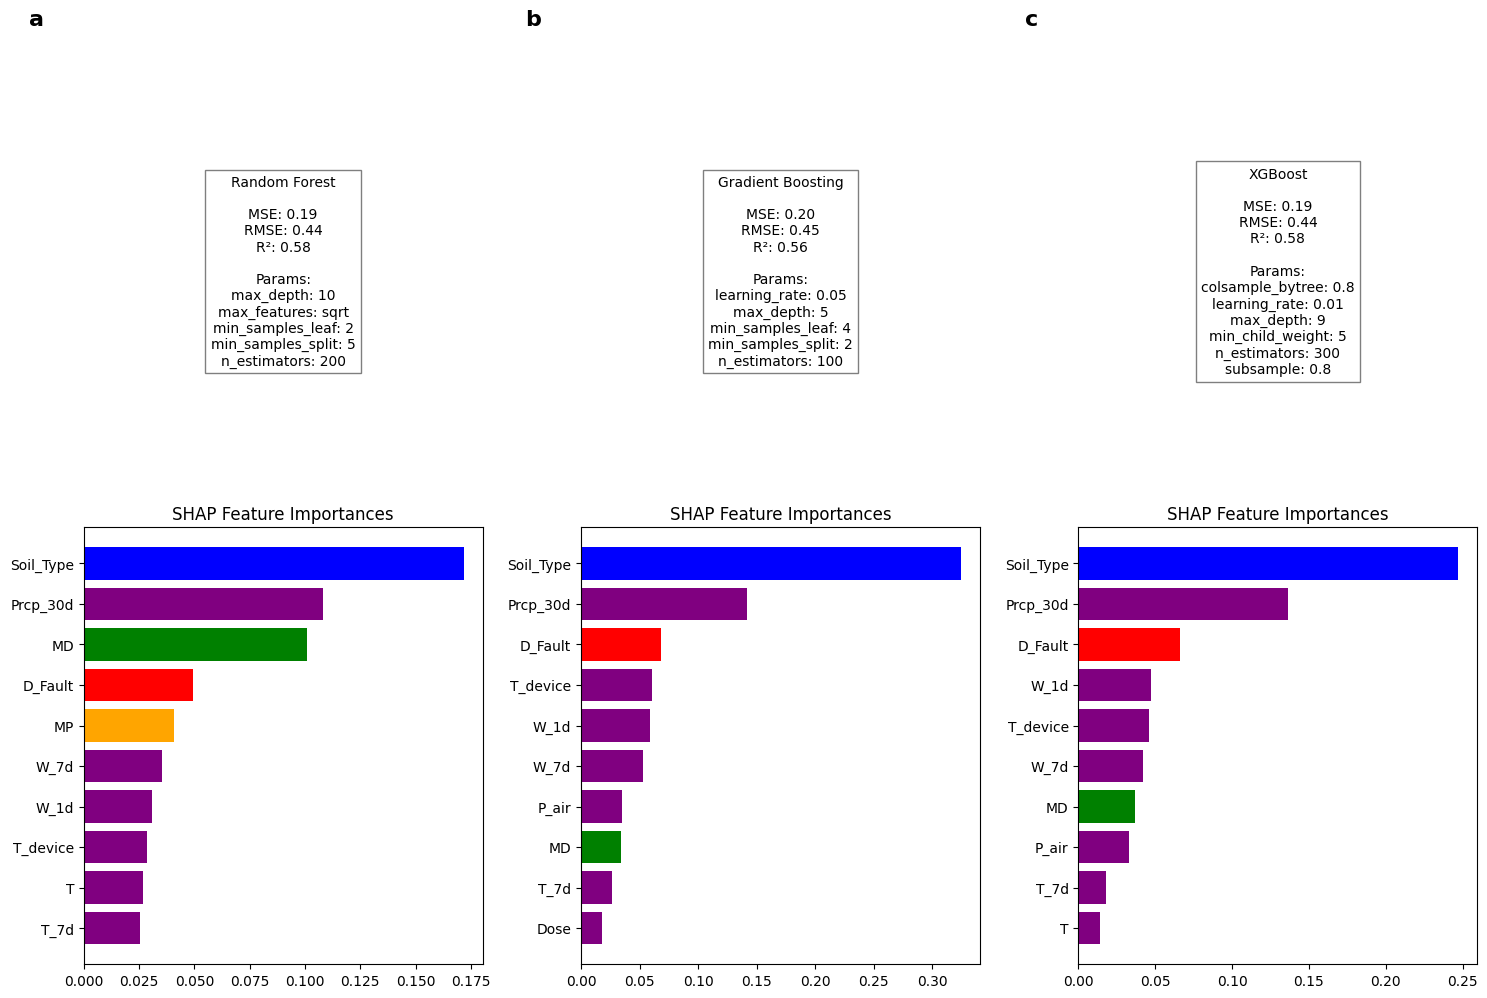

In [3]:


# Define short variable names
short_names = {
    'Soil_Type': 'Soil_Type',
    'Air_Pressure': 'P_air',
    'Device_Temperature': 'T_device',
    'Ambient_Dose_Equivalent': 'Dose',
    'Average_Temperature': 'T',
    'Temperature_1_Day_Before': 'T_1d',
    'Average_Temperature_3_Days_Before': 'T_3d',
    'Average_Temperature_7_Days_Before': 'T_7d',
    'Wind_Speed_1_Day_Before': 'W_1d',
    'Average_Wind_Speed_3_Days_Before': 'W_3d',
    'Average_Wind_Speed_7_Days_Before': 'W_7d',
    'Precipitation_1_Day_Before': 'Prcp_1d',
    'Sum_Precipitation_3_Days_Before': 'Prcp_3d',
    'Sum_Precipitation_7_Days_Before': 'Prcp_7d',
    'Sum_Precipitation_30_Days_Before': 'Prcp_30d',
    'Editor': 'MP',
    'Measuring_Device': 'MD',
    'Distance2Closest_Fault': 'D_Fault'
}

# Define colors for different categories
colors = {
    'Soil_Type': 'blue',
    'MP': 'orange',
    'MD': 'green',
    'P_air': 'purple',
    'T_device': 'purple',
    'Dose': 'purple',
    'T': 'purple',
    'T_1d': 'purple',
    'T_3d': 'purple',
    'T_7d': 'purple',
    'W_1d': 'purple',
    'W_3d': 'purple',
    'W_7d': 'purple',
    'Prcp_1d': 'purple',
    'Prcp_3d': 'purple',
    'Prcp_7d': 'purple',
    'Prcp_30d': 'purple',
    'D_Fault': 'red'
}

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Initialize plot with a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 1]})

# Define the axes
axes_model_metrics = axs[0, :]
axes_shap_values = axs[1, :]

models = {'rf': 'Random Forest', 'gb': 'Gradient Boosting', 'xgb': 'XGBoost'}
model_data = {}
shap_values_data = {}

# Assuming best_models is a dictionary of fitted models
for i, (key, model) in enumerate(best_models.items()):
    # Compute and store metrics
    mse_scores = cross_val_score(model, X_preprocessed, y, groups=data['Group'], cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -mse_scores.mean()
    rmse = np.sqrt(mse)
    r2 = cross_val_score(model, X_preprocessed, y, groups=data['Group'], cv=group_kfold, scoring='r2', n_jobs=-1).mean()
    model_data[key] = (mse, rmse, r2)
    
    # Get best parameters from grid search
    best_params = grid_searches[key].best_params_

    # Format parameters for display
    params_text = "\n".join([f"{k}: {v}" for k, v in best_params.items()])

    # Display model metrics and best parameters
    axes_model_metrics[i].text(0.5, 0.5, f'{models[key]}\n\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\n\nParams:\n{params_text}',
                               horizontalalignment='center', verticalalignment='center',
                               fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    axes_model_metrics[i].axis('off')
    
    # SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_preprocessed)
    shap_values_data[key] = shap_values  # Store SHAP values for later use
    
    # Calculate mean absolute SHAP values
    mean_shap_values = np.abs(shap_values).mean(axis=0)
    
    # Aggregate SHAP values for the specified categorical features
    categorical_features = ['Soil_Type', 'Editor', 'Measuring_Device']
    aggregated_shap_values = {feature: 0 for feature in categorical_features}
    other_shap_values = {}

    for feature, value in zip(X_preprocessed.columns, mean_shap_values):
        for cat_feature in categorical_features:
            if feature.startswith(cat_feature + '_'):
                aggregated_shap_values[cat_feature] += value
                break
        else:
            other_shap_values[feature] = value
    
    # Combine the aggregated and other SHAP values
    combined_shap_values = {**aggregated_shap_values, **other_shap_values}
    print(combined_shap_values)
    # Prepare data for plotting, restricting to top 10 features
    features = list(combined_shap_values.keys())
    values = list(combined_shap_values.values())
    indices = np.argsort(values)[-10:]
    
    # Apply short names to features
    short_features = [short_names.get(f, f) for f in np.array(features)[indices]]
    colors_for_plot = [colors.get(short_names.get(f, f), 'gray') for f in np.array(features)[indices]]
    
    # Plotting the aggregated SHAP values
    axes_shap_values[i].barh(range(len(indices)), np.array(values)[indices], align='center', color=colors_for_plot)
    axes_shap_values[i].set_yticks(range(len(indices)))
    axes_shap_values[i].set_yticklabels(short_features)
    axes_shap_values[i].set_title('SHAP Feature Importances')

# Add 'a', 'b', 'c' labels
for i, label in enumerate(['a', 'b', 'c']):
    axes_model_metrics[i].text(-0.1, 1.1, label, transform=axes_model_metrics[i].transAxes,
                               fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('Figure4.png',dpi=300)
plt.show()
